# Tecator experiments

This is a Jupytor notebook that reproduces some of the results shown in paper "Collinear datasets augmentation using Procrustes validation sets" (in a more simple form).  

First we load packages and define ANN regression model for Tecator experiments.

In [3]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, TensorDataset
from prcv.methods import pcvpls
from pandas import read_csv
from math import sqrt

# ANN learning parameters
N_EPOCH = 300    # number of epochs
LR = 0.0001      # learning rate
BATCH_SIZE = 10  # batch size

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# class for ANN model
class ANNModel(nn.Module):
    def __init__(self):
        super(ANNModel, self).__init__()
        self.fc1 = nn.Linear(in_features=100, out_features=150)
        self.fc2 = nn.Linear(in_features=150, out_features=200)
        self.fc3 = nn.Linear(in_features=200, out_features=150)
        self.fc4 = nn.Linear(in_features=150, out_features=100)
        self.fc5 = nn.Linear(in_features=100, out_features=50)
        self.fc6 = nn.Linear(in_features=50, out_features=1)

    def forward(self, x):
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        x = nn.functional.relu(x)
        x = self.fc3(x)
        x = nn.functional.relu(x)
        x = self.fc4(x)
        x = nn.functional.relu(x)
        x = self.fc5(x)
        x = nn.functional.relu(x)
        x = self.fc6(x)
        return x

# method for making predictions (returns predicted response values, RMSE and R2)
def predict(model, X, Y):
    X_tensor = torch.from_numpy(X).float().to(device)
    Yp_tensor = model(X_tensor)
    Yp = Yp_tensor.detach().cpu().numpy()
    SSE = np.sum((Y - Yp)**2)
    SSY = np.sum((Y - Y.mean())**2)
    RMSE = sqrt(SSE / X.shape[0])
    R2 = 1 - SSE/SSY

    return Yp, RMSE, R2

# method for counting all model parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [4]:
# initialize model and show number of parameters
model = ANNModel()
count_parameters(model)

95701

Function which generates `n` PV-sets using PLS based algorithm with `ncomp` components and random splits into `nseg` segments and then train the ANN model based on the augmented data. If `n = 0` model will be trained using the original training set, without augmentation.

In [5]:
def doit(Xc, Yc, n, ncomp, nseg):

    # initially augmented training set is the same as the original one
    Xc_aug = Xc
    Yc_aug = Yc

    if (n > 0):
        # loop for generation of additional data points using PCV for PLS and adding them
        # to the training set
        cv = {'type': 'rand', 'nseg': nseg}
        for i in range(n):
            Xpv, D = pcvpls(Xc, Yc, ncomp = ncomp, center = True, scale = False, cv = cv)
            Xc_aug = np.concatenate((Xc_aug, Xpv), axis = 0)
            Yc_aug = np.concatenate((Yc_aug, Yc), axis = 0)

    # turn training set to Torch tensors
    Xc_tensor = torch.from_numpy(Xc_aug).float().to(device)
    Yc_tensor = torch.from_numpy(Yc_aug).float().to(device)

    # create Torch dataset and data loader with given batch size
    cal = TensorDataset(Xc_tensor, Yc_tensor)
    cal_loader = DataLoader(cal, batch_size = BATCH_SIZE, shuffle = True)

    # learning using given number of epochs and learning rate
    model = ANNModel().to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = LR)
    losses = np.zeros(N_EPOCH, dtype = np.float64)
    for epoch in range(N_EPOCH):
        for i, (inputs, targets) in enumerate(cal_loader):
            # zero the gradients
            optimizer.zero_grad()

            # forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            losses[epoch] += loss

            # backward pass and optimization
            loss.backward()
            optimizer.step()

    return model, losses

Load, split and preprocess Tecator dataset.

In [7]:
# load data from CSV file and split to X and Y
d = read_csv('./Tecator.csv', delimiter=";", decimal=",")
Y = d.iloc[0:215, 1:2].to_numpy()
X = d.iloc[0:215, 2:102].to_numpy()

# calibration (training) set
Xc = X[0:170, ]
Yc = Y[0:170, ]

# test set
Xt = X[170:215, ]
Yt = Y[170:215, ]

# compute mean and standard deviation for training set predictors
mXc = Xc.mean(axis=0)
sXc = Xc.std(axis=0)

# standardize both sets
Xc = (Xc - mXc) / sXc
Xt = (Xt - mXc) / sXc

# compute mean of training set response
mYc = Yc.mean(axis=0)
sYc = Yc.std(axis=0)

# mean center responses
Yc = (Yc - mYc)
Yt = (Yt - mYc)

Create two models. Model 1 is based on original training set. Model 2 is based on training set augmented with 10 PV-sets computed using 10 latent variables and cross-validation splits with 10 segments.

In [8]:

model1, losses1 = doit(Xc, Yc,  0,  0,  0)
model2, losses2 = doit(Xc, Yc, 10, 10, 10)

Use both models to get predictions for the test set.

In [9]:
Yp1, RMSE1, R21 = predict(model1, Xt, Yt)
Yp2, RMSE2, R22 = predict(model2, Xt, Yt)
print(RMSE1, R21)
print(RMSE2, R22)

3.428481518744814 0.9367959597419779
1.0722756881393958 0.9938176422264953


Now we repeat the training/test procedure 10 times, save all RMSE (this will take some time).

In [13]:
n = 10
RMSE1_v = np.zeros(n)
RMSE2_v = np.zeros(n)
for i in range(n):
    model1, losses1 = doit(Xc, Yc,  0,  0,  0)
    model2, losses2 = doit(Xc, Yc, 10, 10, 10)
    Yp1, RMSE1_v[i], R21 = predict(model1, Xt, Yt)
    Yp2, RMSE2_v[i], R22 = predict(model2, Xt, Yt)
    print(i, R21, R22)

0 0.9269046371785725 0.9916350643120982
1 0.9269002203828312 0.9910722355109596
2 0.9260847223024962 0.9909522662669333
3 0.925316892190169 0.9915229377504476
4 0.9261514320879898 0.9906851332143332
5 0.9190942108732386 0.9915053286024021
6 0.9142863343989887 0.993060172254081
7 0.915745324985064 0.9926044222850111
8 0.9245070480469515 0.9923687692603494
9 0.9229112111133343 0.9922593625433037


Compare the results visually.

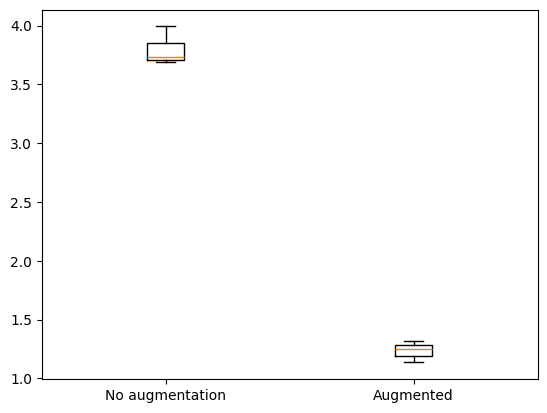

In [16]:
p = plt.boxplot(np.column_stack((RMSE1_v, RMSE2_v)), labels = ["No augmentation", "Augmented"])